![Colegio Bourbaki](./Images/Bourbaki.png)

# Machine Learning & AI

### Red convolucional de grafos ponderados geográficamente (Geographically Weighted Graph Convolutional Network)

**Introducción a los Grafos Ponderados Geográficamente**

En un grafo ponderado geográficamente, las aristas no solo representan conexiones entre nodos, sino que también incluyen pesos que reflejan distancias geográficas, similitudes espaciales, o relaciones geográficas específicas. Este tipo de modelado es útil en contextos donde la proximidad geográfica influye en las interacciones, como en análisis de transporte, estudios ambientales, o redes sociales con datos geolocalizados.
Red Convolucional de Grafos Ponderados Geográficamente

Las Redes Convolucionales de Grafos Ponderados Geográficamente combinan la capacidad de las GCN para capturar la estructura topológica del grafo con el uso de pesos geográficos para ajustar las contribuciones de los nodos vecinos. La idea es incorporar información espacial de manera explícita en el proceso de aprendizaje, lo que permite:

* Modelar influencias geográficas entre los nodos.
* Capturar patrones espaciales que no son evidentes en grafos no ponderados.
* Mejorar la precisión en tareas como clasificación de nodos, predicción de enlaces o regresión de atributos nodales.

**Aplicaciones**

* Transporte y movilidad: Predicción de tráfico o demanda de transporte público, considerando la proximidad geográfica entre estaciones o puntos de interés.
* Análisis ambiental: Modelado de fenómenos naturales, como la calidad del aire o la contaminación, utilizando datos geoespaciales.
* Redes sociales: Análisis de interacciones entre usuarios considerando tanto la estructura de la red como su localización geográfica.

En conclusión, las Redes Convolucionales de Grafos Ponderados Geográficamente ofrecen una poderosa herramienta para integrar información geográfica y espacial en el análisis de datos complejos estructurados como grafos, lo que permite mejorar la precisión de los modelos y capturar relaciones espaciales relevantes.


Una Red Convolucional de Grafos Ponderados Geográficamente (GCN por sus siglas en inglés, Geographically Weighted Graph Convolutional Network) es una extensión de las redes convolucionales de grafos que incorpora información espacial y geográfica en el análisis de datos que tienen una estructura de grafo. A diferencia de las redes convolucionales tradicionales, que se aplican a datos organizados en forma de cuadrícula (como imágenes), las GCN están diseñadas para procesar datos en forma de grafos, donde los nodos y sus conexiones representan relaciones complejas.

**Discusión**

Se puede afirmar que las Redes Neuronales Convolucionales (CNN) son un caso especial de las Redes Neuronales de Grafos (GNN), particularmente cuando se considera la estructura de una imagen como un grafo regular. A continuación, vemos por qué:
1. Representación de Imágenes como Grafos

    Una imagen puede ser vista como una rejilla regular, donde cada píxel es un nodo, y cada nodo está conectado con sus píxeles vecinos (por ejemplo, usando una vecindad de 4 o 8 vecinos).
    Esta rejilla puede representarse como un grafo, donde los nodos corresponden a los píxeles y los bordes conectan a los píxeles adyacentes.

2. Convolución como Operación en Grafos

    En una CNN, las convoluciones son operaciones locales que agregan información de una vecindad fija (por ejemplo, un kernel de 3x3 considera 8 píxeles vecinos).
    En una GNN, el marco de paso de mensajes (message-passing) generaliza esta idea: los nodos agregan información de sus vecinos en base a la estructura del grafo. La función de agregación puede ser una transformación lineal aprendida, una suma ponderada o una función más compleja.
    En el caso de una imagen, los vecinos de un píxel (nodo) están definidos por la estructura de la rejilla, lo que hace que la operación de convolución sea una instancia específica del paso de mensajes donde la estructura del grafo es la rejilla regular.

3. Compartición de Pesos (Weight Sharing)

    Las CNN utilizan compartición de pesos, es decir, el mismo filtro (kernel de convolución) se aplica a toda la imagen. Esto se puede ver como aplicar la misma función de paso de mensajes a todos los nodos del grafo de la rejilla.
    En GNNs, no siempre se utiliza la compartición de pesos de manera global a través del grafo. Sin embargo, en ciertos tipos de GNN, como las Redes Convolucionales de Grafos (GCN), la función de agregación suele compartirse entre todos los nodos.

4. Topología Fija vs. Arbitraria

    Las CNN asumen una estructura de rejilla fija, lo que las hace eficientes para datos de imágenes. Esta estructura fija permite definir operaciones de convolución predeterminadas.
    Las GNN están diseñadas para trabajar con estructuras de grafos arbitrarias, donde la topología no es fija y puede variar de una instancia a otra. Esta flexibilidad permite que las GNN generalicen más allá de datos tipo rejilla a grafos con relaciones complejas.

5. Perspectiva Espectral

    Desde una perspectiva espectral, la operación de convolución en una CNN puede entenderse como una filtración en el dominio de frecuencia. En GNNs, la convolución espectral en grafos generaliza esta idea utilizando el Laplaciano del grafo para definir operaciones de tipo convolución en grafos generales.

#### Contexto: Aplicación en modelos geográficos

Utilizaremos un dataset de propiedades de Airbnb en la zona de San Diego, California, USA. El dataset se encuentra en formato GEOJSON.

![Colegio Bourbaki](./Images/Data.png)

#### Librerias

In [1]:
import esda
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import seaborn as sns
import torch
import torch.nn.functional as F
import libpysal
import plotly.graph_objects as go

from pysal.lib import weights
from scipy import sparse
from scipy.sparse import csr_matrix, diags, csgraph
from sklearn.metrics import mean_squared_error as mse, median_absolute_error as mae, r2_score
from torch import nn
from typing import Tuple, List, Optional

In [2]:
# Configuration dictionary
config = {
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "graph": {
        "adj": {
            "k": 40,
        },
    },
    "model": {
        "hidden_layers": [8],
        "dropouts": [0.5],
        "learning_rate": 5e-2,
        "weight_decay_ratio": 0.1,
    },
    "training": {
        "epochs": 50000,
        "print_interval": 1000,
        "error_type": "MAPE"
    },
}

In [3]:
device = config['device']

In [4]:
device

device(type='cuda')

#### Funciones de ayuda

In [5]:
def mkdir(path: str) -> None:
    """
    Create a directory if it does not exist.

    Args:
        path (str): The directory path to create.

    Raises:
        OSError: If the directory cannot be created and does not already exist.
    """
    if not os.path.exists(path):
        try:
            os.makedirs(path)
            print(f"Directory created at: {path}")
        except OSError as e:
            raise OSError(f"Failed to create directory {path}: {e}")
    else:
        print("--- A folder with the same name already exists! ---")

In [6]:
def row_normalize(mx: sparse.spmatrix) -> sparse.spmatrix:
    """
    Row-normalize a sparse matrix.

    Each row of the matrix will sum to 1. Rows with a sum of 0 are left unchanged.

    Args:
        mx (sparse.spmatrix): The sparse matrix to normalize.

    Returns:
        sparse.spmatrix: The row-normalized sparse matrix.

    Raises:
        TypeError: If the input is not a scipy sparse matrix.
    """
    if not sparse.isspmatrix(mx):
        raise TypeError("Input matrix must be a scipy sparse matrix.")

    rowsum = np.array(mx.sum(axis=1)).flatten()
    r_inv = np.power(rowsum, -1, where=rowsum != 0)
    r_inv[np.isinf(r_inv)] = 0.0
    r_mat_inv = diags(r_inv)
    normalized_mx = r_mat_inv.dot(mx)
    return normalized_mx

In [7]:
def make_sym_matrix_boolean_sum(mx: np.ndarray, type: str) -> np.ndarray:
    """
    Make a symmetric adjacency matrix by taking the boolean OR of the matrix and its transpose.

    This ensures the adjacency matrix is symmetric regardless of the original definition.

    Args:
        mx (np.ndarray): The original adjacency matrix.

    Returns:
        np.ndarray: The symmetric adjacency matrix.
    """
    if not isinstance(mx, np.ndarray):
        raise TypeError("Input must be a NumPy array.")
    if type == "soft":
        return 1 * np.logical_or(mx, mx.T)
    return (mx + mx.T > 0).astype(int)

In [8]:
def renormalized_trick_mx(mx: np.ndarray) -> np.ndarray:
    """
    Add self-connections to the adjacency matrix by adding an identity matrix.

    Args:
        mx (np.ndarray): The original adjacency matrix.

    Returns:
        np.ndarray: The adjacency matrix with self-connections.
    """
    if not isinstance(mx, np.ndarray):
        raise TypeError("Input must be a NumPy array.")
    identity = np.eye(mx.shape[0], dtype=mx.dtype)
    return mx + identity

In [ ]:
def renormalized_trick_laplacian_old(mx: np.ndarray) -> np.ndarray:
    """
    Compute the normalized Laplacian matrix using SciPy's csgraph.

    This function returns the normalized Laplacian matrix defined as:
    L = I - D^(-1/2) A D^(-1/2),
    where A is the adjacency matrix (with optional self-connections),
    and D is the degree matrix.

    The normalized Laplacian matrix is commonly used in spectral graph theory
    and is particularly useful for tasks like spectral clustering.

    Args:
        mx (np.ndarray): The adjacency matrix with self-connections (if needed).

    Returns:
        np.ndarray: The normalized Laplacian matrix L = I - D^(-1/2) A D^(-1/2).

    Raises:
        TypeError: If the input is not a NumPy array.
    """
    if not isinstance(mx, np.ndarray):
        raise TypeError("Input must be a NumPy array.")
    laplacian = csgraph.laplacian(mx, normed=True)
    identity = np.eye(mx.shape[0], dtype=mx.dtype)
    return identity - laplacian

In [ ]:
def renormalized_trick_laplacian(mx_tilde: np.ndarray) -> np.ndarray:
    """
    Compute the renormalized adjacency matrix D^(-1/2) A D^(-1/2).

    This function returns the renormalized adjacency matrix, which normalizes
    the adjacency matrix using the degree matrix. It is commonly used in
    Graph Convolutional Networks (GCNs) to ensure stability and consistency
    during message passing.

    The output matrix is related to the normalized Laplacian as:
    L = I - D^(-1/2) A D^(-1/2).

    Args:
        mx_tilde (np.ndarray): The adjacency matrix with self-connections (if needed).

    Returns:
        np.ndarray: The renormalized adjacency matrix D^(-1/2) A D^(-1/2).

    Raises:
        TypeError: If the input is not a NumPy array.
        ValueError: If the degree matrix is singular and cannot be inverted.
    """
    if not isinstance(mx_tilde, np.ndarray):
        raise TypeError("Input must be a NumPy array.")
    degree_tilde = np.diag(np.sum(mx_tilde, axis=1))
    try:
        D_tilde_inv_sqrt = np.linalg.inv(np.sqrt(degree_tilde))
    except np.linalg.LinAlgError:
        raise ValueError("Degree matrix is singular and cannot be inverted.")
    return D_tilde_inv_sqrt @ mx_tilde @ D_tilde_inv_sqrt

In [11]:
def ensure_connected(knn_matrix: np.ndarray, db: gpd.GeoDataFrame) -> np.ndarray:
    """
    Ensure that the KNN adjacency matrix is fully connected by adding edges
    between disconnected components.

    Args:
        knn_matrix (np.ndarray): The KNN adjacency matrix.
        db (gpd.GeoDataFrame): GeoDataFrame containing spatial data.

    Returns:
        np.ndarray: The connected KNN adjacency matrix.
    """
    graph = csr_matrix(knn_matrix)
    n_components, labels = csgraph.connected_components(
        csgraph=graph, directed=False, return_labels=True
    )

    if n_components == 1:
        print("The weights matrix is fully connected.")
        return knn_matrix

    print(
        f"\nThe weights matrix is not fully connected: There are {n_components} disconnected components."
    )

    # Find the centroids of each component
    centroids = []
    for i in range(n_components):
        component = db.iloc[np.where(labels == i)[0]]
        centroid = component.geometry.union_all().centroid
        centroids.append(centroid)

    # Connect each component to the next one
    for i in range(n_components - 1):
        point_a = centroids[i]
        point_b = centroids[i + 1]
        distance_between = point_a.distance(point_b)
        print(
            f"\nConnecting component {i} to component {i + 1} with distance {distance_between:.4f}"
        )

        # Find the closest pair of points between component i and i+1
        component_i = db.iloc[np.where(labels == i)[0]]
        component_j = db.iloc[np.where(labels == i + 1)[0]]

        min_dist = float("inf")
        min_pair = (None, None)

        for idx_a, geom_a in component_i.geometry.items():
            for idx_b, geom_b in component_j.geometry.items():
                dist = geom_a.distance(geom_b)
                if dist < min_dist:
                    min_dist = dist
                    min_pair = (idx_a, idx_b)

        if min_pair[0] is not None and min_pair[1] is not None:
            knn_matrix[min_pair[0], min_pair[1]] = 1
            knn_matrix[min_pair[1], min_pair[0]] = 1
            print(
                f"\nConnected node {min_pair[0]} with node {min_pair[1]}  (distance: {min_dist:.4f})"
            )
        else:
            print(f"\nFailed to connect component {i} to component {i + 1}")

    # Re-check connectivity
    graph = csr_matrix(knn_matrix)
    n_components, labels = csgraph.connected_components(
        csgraph=graph, directed=False, return_labels=True
    )

    if n_components > 1:
        print(f"\nUnable to fully connect the graph. {n_components} components remain.")
    else:
        print("\nThe graph is now fully connected!")

    return knn_matrix

In [12]:
def prepare_adjacency_matrix(
    db: gpd.GeoDataFrame, k: int, connect_graph: bool, type: str
) -> Tuple[torch.FloatTensor, libpysal.weights.distance.KNN, np.ndarray]:
    """
    Create and normalize the adjacency matrix using K-Nearest Neighbors.

    Args:
        db (gpd.GeoDataFrame): The GeoDataFrame containing spatial data
        with a 'geometry' column.
        k (int, optional): Number of nearest neighbors. Defaults to 20.

    Returns:
        torch.Tensor: The normalized Laplacian adjacency matrix as a PyTorch tensor
        on the specified device.
    """
    knn = weights.KNN.from_dataframe(db, geom_col="geometry", k=k)
    a_knn = make_sym_matrix_boolean_sum(knn.full()[0], type)

    # Ensure the adjacency matrix is connected
    if connect_graph:
        a_knn_connected = ensure_connected(a_knn, db)
    else: 
        a_knn_connected = a_knn

    a_tilde = renormalized_trick_mx(a_knn_connected)
    laplacian = renormalized_trick_laplacian(a_tilde)
    return torch.FloatTensor(laplacian), knn, a_knn_connected

In [13]:
def check_symmetric(a: np.ndarray, tol: float = 1e-8) -> bool:
    """
    Check if a matrix is symmetric within a specified tolerance.

    Args:
        a (np.ndarray): The matrix to check.
        tol (float, optional): Tolerance for symmetry. Defaults to 1e-8.

    Returns:
        bool: True if the matrix is symmetric within the tolerance, False otherwise.
    """
    if not isinstance(a, np.ndarray):
        raise TypeError("Input must be a NumPy array.")
    return bool(np.all(np.abs(a - a.T) < tol))

In [14]:
def step(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    input_tensor: torch.Tensor,
    idx: torch.Tensor,
    target_tensor: torch.Tensor,
    adj: torch.Tensor,
) -> float:
    """
    Perform a training step with the given model and optimizer.

    Trains the model on the specified indices using Mean Squared Error loss.

    Args:
        model (nn.Module): The neural network model to train.
        optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
        input_tensor (torch.Tensor): The input feature tensor.
        idx (torch.Tensor): The indices of the training samples.
        target_tensor (torch.Tensor): The target tensor.
        adj (torch.Tensor): The adjacency matrix tensor.

    Returns:
        float: The mean loss value for the training step.
    """
    with torch.autograd.set_detect_anomaly(True):
        model.train()
        optimizer.zero_grad()
        output = model(input_tensor, adj)
        loss = F.mse_loss(
            output[idx], target_tensor[idx], reduction='none')
        loss.backward(
            torch.reshape(torch.ones(len(idx)).to(device), (len(idx), 1)),
            retain_graph=False,
        )
        optimizer.step()
        return loss.mean().item()

In [15]:
def evaluate_error(
    model: nn.Module,
    input_tensor: torch.Tensor,
    idx: torch.Tensor,
    target_tensor: torch.Tensor,
    adj: torch.Tensor,
    error_type: str,
) -> float:
    """
    Evaluate the model's performance on a validation set using a user defined rror.

    Args:
        model (nn.Module): The neural network model to evaluate.
        input_tensor (torch.Tensor): The input feature tensor.
        idx (torch.Tensor): The indices of the validation samples.
        target_tensor (torch.Tensor): The target tensor.
        adj (torch.Tensor): The adjacency matrix tensor.
        error_type(str): The error type to use. Can be "MSE" or "MAPE".

    Returns:
        float: The mean MAPE on the validation set.
    """
    model.eval()
    #with torch.no_grad():
    with torch.inference_mode():
        if error_type == "MSE":
            output = model(input_tensor, adj)
            error = (
                F.mse_loss(output[idx], target_tensor[idx], reduction='none')
            )
        elif error_type == "MAPE":
            output = model(input_tensor, adj)
            error = (
                F.l1_loss(
                    output[idx], target_tensor[idx], reduction='none')
                / target_tensor[idx]
            )
        else:
            raise ValueError("Invalid error type. Must be 'MSE' or 'MAPE'.")
    return error.mean().item()

In [16]:
def return_results(
    model: nn.Module,
    input_tensor: torch.Tensor,
    idx: torch.Tensor,
    target_tensor: torch.Tensor,
    adj: torch.Tensor,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate and return the model's predictions and corresponding targets.

    Args:
        model (nn.Module): The trained neural network model.
        input_tensor (torch.Tensor): The input feature tensor.
        idx (torch.Tensor): The indices for which to generate predictions.
        target_tensor (torch.Tensor): The target tensor.
        adj (torch.Tensor): The adjacency matrix tensor.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing the predicted values 
        and the ground truth values as NumPy arrays.
    """
    model.eval()
    #with torch.no_grad():
    with torch.inference_mode():
        output = model(input_tensor, adj)
    predictions = output[idx].cpu().detach().numpy()
    targets = target_tensor[idx].cpu().detach().numpy()
    return predictions, targets

### Arquitecturas GNN

In [ ]:
class GraphConvolution(nn.Module):
    """
    Basic graph convolution layer that incorporates spatially lagged features.

    This layer performs the operation: H = activation(A * X * W + b)

    Attributes:
        f_in (int): Number of input features.
        f_out (int): Number of output features.
        use_bias (bool): Whether to include a bias term.
        activation (nn.Module): Activation function to apply.
        weight (nn.Parameter): Weight matrix.
        bias (nn.Parameter or None): Bias vector.
    """

    def __init__(
        self,
        f_in: int,
        f_out: int,
        use_bias: bool = True,
        activation: Optional[nn.Module] = nn.ReLU(),
    ):
        """
        Initialize the GraphConvolution layer.

        Args:
            f_in (int): Number of input features.
            f_out (int): Number of output features.
            use_bias (bool, optional): Whether to include a bias term. Defaults to True.
            activation (nn.Module, optional): Activation function. Defaults to nn.ReLU().
        """
        super(GraphConvolution, self).__init__()
        self.f_in = f_in
        self.f_out = f_out
        self.use_bias = use_bias
        self.activation = activation

        # Define weight and bias parameters
        self.weight = nn.Parameter(torch.FloatTensor(f_in, f_out))
        if self.use_bias:
            self.bias = nn.Parameter(torch.FloatTensor(f_out))
        else:
            self.register_parameter("bias", None)

        self.initialize_weights()

    def initialize_weights(self) -> None:
        """
        Initialize the weights and biases of the layer.

        Weights are initialized to ones, and biases are initialized to zeros if used.
        """
        nn.init.constant_(self.weight, 1.0)
        if self.use_bias:
            nn.init.constant_(self.bias, 0.0)

    def forward(self, input: torch.Tensor, adj: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the graph convolution layer.

        Args:
            input (torch.Tensor): Input feature matrix of shape (N, f_in).
            adj (torch.Tensor): Adjacency matrix of shape (N, N).

        Returns:
            torch.Tensor: Output feature matrix of shape (N, f_out).
        """
        support = torch.mm(input, self.weight)
        out = torch.mm(adj, support)  # adj should be pre-normalized

        if self.use_bias:
            out += self.bias
        if self.activation is not None:
            out = self.activation(out)
        return out


class GCN(nn.Module):
    """
    Graph Convolutional Network (GCN) model.

    This model consists of multiple GraphConvolution layers followed by an output layer.

    Attributes:
        layers (nn.Sequential): Sequence of hidden GraphConvolution layers.
        dropouts (List[float]): List of dropout rates for each hidden layer.
        out_layer (GraphConvolution): The final output graph convolution layer.
    """

    def __init__(
        self,
        f_in: int,
        n_classes: int,
        hidden: List[int],
        dropouts: List[float],
    ):
        """
        Initialize the GCN model.

        Args:
            f_in (int): Number of input features.
            n_classes (int): Number of output classes.
            hidden (List[int]): List containing the number of hidden units for each hidden layer.
            dropouts (List[float]): List containing dropout rates for each hidden layer.

        Raises:
            ValueError: If the lengths of hidden and dropouts lists do not match.
        """
        super(GCN, self).__init__()
        if len(hidden) != len(dropouts):
            raise ValueError("Lengths of hidden and dropouts lists must match.")

        self.layers = nn.Sequential()
        for i, (f_in_layer, f_out_layer) in enumerate(
            zip([f_in] + hidden[:-1], hidden)
        ):
            self.layers.add_module(
                f"GraphConvolution_{i}", GraphConvolution(f_in_layer, f_out_layer)
            )

        self.dropouts = dropouts
        self.out_layer = GraphConvolution(
            hidden[-1], n_classes, activation=None
        )  # No activation in output layer

    def forward(self, x: torch.Tensor, adj: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the GCN model.

        Args:
            x (torch.Tensor): Input feature matrix of shape (N, f_in).
            adj (torch.Tensor): Adjacency matrix of shape (N, N).

        Returns:
            torch.Tensor: Output feature matrix of shape (N, n_classes).
        """
        for i, layer in enumerate(self.layers):
            x = layer(x, adj)
            if self.dropouts[i] > 0:
                x = F.dropout(x, self.dropouts[i], training=self.training)

        x = self.out_layer(x, adj)
        return x


class GWGraphConvolution(nn.Module):
    """
    Geographically Weighted Graph Convolution layer.

    This layer incorporates locally parameterized weights for each node, allowing
    each node to adjust the input features in a specific manner.

    Attributes:
        f_in (int): Number of input features.
        f_out (int): Number of output features.
        num_nodes (int): Number of nodes in the graph.
        use_bias (bool): Whether to include a bias term.
        activation (nn.Module): Activation function to apply.
        gwr_weight (nn.Parameter): Matrix of geographically weighted parameters specific to each node.
        weight (nn.Parameter): Weight matrix.
        bias (nn.Parameter or None): Bias vector.
    """

    def __init__(
        self,
        f_in: int,
        f_out: int,
        num_nodes: int,
        use_bias: bool = True,
        activation: Optional[nn.Module] = nn.ReLU(),
    ):
        """
        Initialize the GWGraphConvolution layer.

        Args:
            f_in (int): Number of input features.
            f_out (int): Number of output features.
            num_nodes (int): Number of nodes in the graph.
            use_bias (bool, optional): Whether to include a bias term. Defaults to True.
            activation (nn.Module, optional): Activation function. Defaults to nn.ReLU().
        """
        super(GWGraphConvolution, self).__init__()
        self.f_in = f_in
        self.f_out = f_out
        self.num_nodes = num_nodes
        self.use_bias = use_bias
        self.activation = activation

        # Geographically weighted parameters specific to each node
        self.gwr_weight = nn.Parameter(torch.FloatTensor(num_nodes, f_in))
        self.weight = nn.Parameter(torch.FloatTensor(f_in, f_out))
        if self.use_bias:
            self.bias = nn.Parameter(torch.FloatTensor(f_out))
        else:
            self.register_parameter("bias", None)

        self.initialize_weights()

    def initialize_weights(self) -> None:
        """
        Initialize the weights and biases of the layer.

        GWR weights and standard weights are initialized to ones, and biases are initialized
        to zeros if used.
        """
        nn.init.constant_(self.weight, 1.0)
        nn.init.constant_(self.gwr_weight, 1.0)
        if self.use_bias:
            nn.init.constant_(self.bias, 0.0)

    def forward(self, input: torch.Tensor, adj: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the GWGraphConvolution layer.

        Args:
            input (torch.Tensor): Input feature matrix of shape (N, f_in).
            adj (torch.Tensor): Adjacency matrix of shape (N, N).

        Returns:
            torch.Tensor: Output feature matrix of shape (N, f_out).
        """
        # Element-wise multiplication with geographically weighted parameters specific to each node
        gwr_support = input * self.gwr_weight  # Shape: (N, f_in)
        support = torch.mm(adj, gwr_support)  # Shape: (N, f_in)
        out = torch.mm(support, self.weight)  # Shape: (N, f_out)

        if self.use_bias:
            out += self.bias
        if self.activation is not None:
            out = self.activation(out)
        return out


class GWGCN(nn.Module):
    """mn
    Geographically Weighted Graph Convolutional Network (GWGCN) model.

    This model consists of multiple GWGraphConvolution layers followed by an output layer.

    Attributes:
        layers (nn.Sequential): Sequence of hidden GWGraphConvolution layers.
        dropouts (List[float]): List of dropout rates for each hidden layer.
        out_layer (GWGraphConvolution): The final output GWGraphConvolution layer.
    """

    def __init__(
        self,
        f_in: int,
        n_classes: int,
        hidden: List[int],
        dropouts: List[float],
        num_nodes: int,
    ):
        """
        Initialize the GWGCN model.

        Args:
            f_in (int): Number of input features.
            n_classes (int): Number of output classes.
            hidden (List[int]): List containing the number of hidden units for each hidden layer.
            dropouts (List[float]): List containing dropout rates for each hidden layer.
            num_nodes (int): Number of nodes in the graph.

        Raises:
            ValueError: If the lengths of hidden and dropouts lists do not match.
        """
        super(GWGCN, self).__init__()
        if len(hidden) != len(dropouts):
            raise ValueError("Lengths of hidden and dropouts lists must match.")

        self.layers = nn.Sequential()
        for i, (f_in_layer, f_out_layer) in enumerate(
            zip([f_in] + hidden[:-1], hidden)
        ):
            self.layers.add_module(
                f"GWGraphConvolution_{i}",
                GWGraphConvolution(f_in_layer, f_out_layer, num_nodes),
            )

        self.dropouts = dropouts
        self.out_layer = GWGraphConvolution(
            hidden[-1], n_classes, num_nodes, activation=None
        )  # No activation in output layer

    def forward(self, x: torch.Tensor, adj: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the GWGCN model.

        Args:
            x (torch.Tensor): Input feature matrix of shape (N, f_in).
            adj (torch.Tensor): Adjacency matrix of shape (N, N).

        Returns:
            torch.Tensor: Output feature matrix of shape (N, n_classes).
        """
        for i, layer in enumerate(self.layers):
            x = layer(x, adj)
            if self.dropouts[i] > 0:
                x = F.dropout(x, self.dropouts[i], training=self.training)

        x = self.out_layer(x, adj)
        return x


A continuación, se presenta una descripción detallada de las clases implementadas para **Graph Convolutional Networks (GCN)** y **Geographically Weighted Graph Convolutional Networks (GWGCN)** en **PyTorch**. Estas clases están diseñadas para incorporar **pesos geográficamente específicos por nodo**, permitiendo que cada nodo ajuste sus características de entrada de manera única y capturando relaciones espaciales más complejas y detalladas.

---

**1. Clase `GraphConvolution`**

**Descripción General**

La clase `GraphConvolution` implementa una **capa básica de convolución en grafos**. Esta capa realiza la operación de propagación de información entre nodos a través de la matriz de adyacencia del grafo, permitiendo que el modelo capture dependencias estructurales y espaciales entre los nodos.

**Atributos**

- **`f_in` (int):**  
  Número de características de entrada por nodo.

- **`f_out` (int):**  
  Número de características de salida por nodo.

- **`use_bias` (bool):**  
  Indica si se incluye un término de sesgo en la capa. Por defecto es `True`.

- **`activation` (nn.Module, opcional):**  
  Función de activación a aplicar después de la convolución. Por defecto es `nn.ReLU()`.

- **`weight` (nn.Parameter):**  
  Matriz de pesos de forma `(f_in, f_out)` que transforma las características de entrada.

- **`bias` (nn.Parameter o None):**  
  Vector de sesgo de forma `(f_out,)`. Solo se incluye si `use_bias` es `True`.

**Métodos**

- **`__init__`**  
  Inicializa la capa de convolución con los parámetros especificados y llama al método `initialize_weights()` para inicializar los pesos y sesgos.

- **`initialize_weights`**  
  Inicializa los pesos a unos y los sesgos a ceros si están habilitados.

- **`forward`**  
  Define el paso hacia adelante de la capa, realizando la multiplicación matricial con la matriz de adyacencia y aplicando la activación si está definida.

---

**2. Clase `GCN`**

**Descripción General**

La clase `GCN` define un **modelo completo de Graph Convolutional Network** compuesto por múltiples capas de `GraphConvolution` y capas de dropout opcionales para regularización. Este modelo es capaz de aprender representaciones de nodos que capturan tanto las características individuales como la estructura del grafo.

**Atributos**

- **`layers` (nn.Sequential):**  
  Secuencia de capas ocultas de `GraphConvolution`.

- **`dropouts` (List[float]):**  
  Lista de tasas de dropout correspondientes a cada capa oculta.

- **`out_layer` (GraphConvolution):**  
  Capa de salida de `GraphConvolution` sin función de activación para generar las predicciones finales.

**Métodos**

- **`__init__`**  
  Inicializa el modelo GCN con las capas ocultas y la capa de salida. Verifica que las listas de capas ocultas y dropouts tengan la misma longitud.

- **`forward`**  
  Define el paso hacia adelante del modelo, pasando los datos a través de cada capa de convolución y aplicando dropout según corresponda, finalizando con la capa de salida.

---

**3. Clase `GWGraphConvolution`**

**Descripción General**

La clase `GWGraphConvolution` implementa una **capa de convolución en grafos geográficamente ponderada**. Esta capa incorpora **pesos específicos por nodo**, permitiendo que cada nodo ajuste sus características de entrada de manera única. Esto es especialmente útil para capturar variaciones geográficas y relaciones espaciales más complejas dentro del grafo.

**Atributos**

- **`f_in` (int):**  
  Número de características de entrada por nodo.

- **`f_out` (int):**  
  Número de características de salida por nodo.

- **`num_nodes` (int):**  
  Número total de nodos en el grafo.

- **`use_bias` (bool):**  
  Indica si se incluye un término de sesgo en la capa. Por defecto es `True`.

- **`activation` (nn.Module, opcional):**  
  Función de activación a aplicar después de la convolución. Por defecto es `nn.ReLU()`.

- **`gwr_weight` (nn.Parameter):**  
  Matriz de pesos geográficamente ponderados específicos para cada nodo, de forma `(num_nodes, f_in)`.

- **`weight` (nn.Parameter):**  
  Matriz de pesos de forma `(f_in, f_out)` que transforma las características de entrada.

- **`bias` (nn.Parameter o None):**  
  Vector de sesgo de forma `(f_out,)`. Solo se incluye si `use_bias` es `True`.

**Métodos**

- **`__init__`**  
  Inicializa la capa `GWGraphConvolution` con los parámetros especificados y llama al método `initialize_weights()` para inicializar los pesos y sesgos.

- **`initialize_weights`**  
  Inicializa los pesos geográficamente ponderados y los pesos estándar a unos, y los sesgos a ceros si están habilitados.

- **`forward`**  
  Define el paso hacia adelante de la capa, realizando la multiplicación elemento a elemento de las características de entrada con los pesos específicos de cada nodo, seguido de la multiplicación matricial con la matriz de adyacencia y la aplicación de la función de activación si está definida.

---

**4. Clase `GWGCN`**

**Descripción General**

La clase `GWGCN` define un **modelo completo de Geographically Weighted Graph Convolutional Network (GWGCN)**. Este modelo está compuesto por múltiples capas de `GWGraphConvolution` y capas de dropout opcionales para regularización. La incorporación de **pesos geográficamente específicos por nodo** permite al modelo capturar relaciones espaciales más detalladas y variaciones locales dentro del grafo.

**Atributos**

- **`layers` (nn.Sequential):**  
  Secuencia de capas ocultas de `GWGraphConvolution`.

- **`dropouts` (List[float]):**  
  Lista de tasas de dropout correspondientes a cada capa oculta.

- **`out_layer` (GWGraphConvolution):**  
  Capa de salida de `GWGraphConvolution` sin función de activación para generar las predicciones finales.

### **Métodos**

- **`__init__`**  
  Inicializa el modelo GWGCN con las capas ocultas y la capa de salida. Verifica que las listas de capas ocultas y dropouts tengan la misma longitud. Requiere el número de nodos (`num_nodes`) para inicializar correctamente las capas con pesos específicos por nodo.

- **`forward`**  
  Define el paso hacia adelante del modelo, pasando los datos a través de cada capa de convolución y aplicando dropout según corresponda, finalizando con la capa de salida.

---

#### Carga de Datos

In [17]:
db = gpd.read_file("./Data/regression_db.geojson")
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6110 non-null   int32   
 1   bathrooms           6110 non-null   float64 
 2   bedrooms            6110 non-null   float64 
 3   beds                6110 non-null   float64 
 4   neighborhood        6110 non-null   object  
 5   pool                6110 non-null   int32   
 6   d2balboa            6110 non-null   float64 
 7   coastal             6110 non-null   int32   
 8   price               6110 non-null   float64 
 9   log_price           6110 non-null   float64 
 10  id                  6110 non-null   int32   
 11  pg_Apartment        6110 non-null   int32   
 12  pg_Condominium      6110 non-null   int32   
 13  pg_House            6110 non-null   int32   
 14  pg_Other            6110 non-null   int32   
 15  pg_Townhouse        6110 non-n

* d2balboa: Distance to Balboa Park (San Diego)
* pg stands for Property Group (categorize the property)
* rt stands for room type (nature of the room)

In [18]:
db.head()

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.9311)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.2187 32.74202)


In [19]:
print(db["neighborhood"].unique())

['North Hills' 'Mission Bay' 'Mira Mesa' 'Roseville' 'Loma Portal'
 'La Jolla' 'Pacific Beach' 'Clairemont Mesa' 'College Area' 'Midtown'
 'Ocean Beach' 'Grant Hill' 'Bay Park' 'West University Heights'
 'Moreno Mission' 'Balboa Park' 'Old Town' 'University City'
 'Del Mar Heights' 'City Heights West' 'Little Italy' 'Linda Vista'
 'Park West' 'Scripps Ranch' 'South Park' 'Kensington' 'Bay Ho'
 'East Village' 'Cortez Hill' 'Normal Heights' 'Carmel Valley'
 'Midtown District' 'Marina' 'Rancho Penasquitos' 'La Jolla Village'
 'Grantville' 'Core' 'San Carlos' 'Serra Mesa' 'Rancho Bernadino'
 'Mission Valley' 'North Clairemont' 'Gaslamp Quarter' 'Northwest'
 'Otay Ranch']


In [20]:
print(db["neighborhood"].unique())

['North Hills' 'Mission Bay' 'Mira Mesa' 'Roseville' 'Loma Portal'
 'La Jolla' 'Pacific Beach' 'Clairemont Mesa' 'College Area' 'Midtown'
 'Ocean Beach' 'Grant Hill' 'Bay Park' 'West University Heights'
 'Moreno Mission' 'Balboa Park' 'Old Town' 'University City'
 'Del Mar Heights' 'City Heights West' 'Little Italy' 'Linda Vista'
 'Park West' 'Scripps Ranch' 'South Park' 'Kensington' 'Bay Ho'
 'East Village' 'Cortez Hill' 'Normal Heights' 'Carmel Valley'
 'Midtown District' 'Marina' 'Rancho Penasquitos' 'La Jolla Village'
 'Grantville' 'Core' 'San Carlos' 'Serra Mesa' 'Rancho Bernadino'
 'Mission Valley' 'North Clairemont' 'Gaslamp Quarter' 'Northwest'
 'Otay Ranch']


#### Visualizaciones

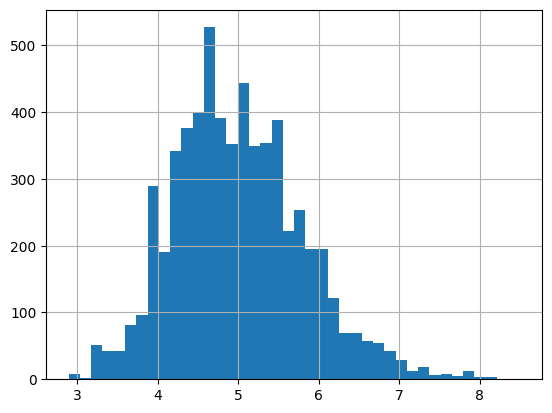

In [21]:
db.log_price.hist(bins=40)
plt.show()

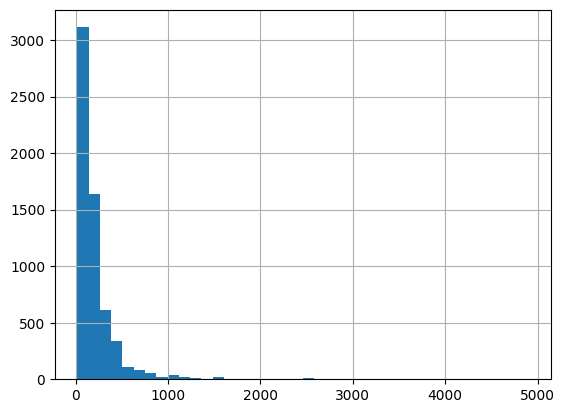

In [23]:
db.price.hist(bins=40)
plt.show()

In [24]:
numeric_cols = db.select_dtypes(include=["int32", "float64"]).columns.tolist()
# Optional: Remove identifier columns if not needed
non_predictive = ["id", "price", "log_price"]  # Adjust as necessary
numeric_cols = [col for col in numeric_cols if col not in non_predictive]

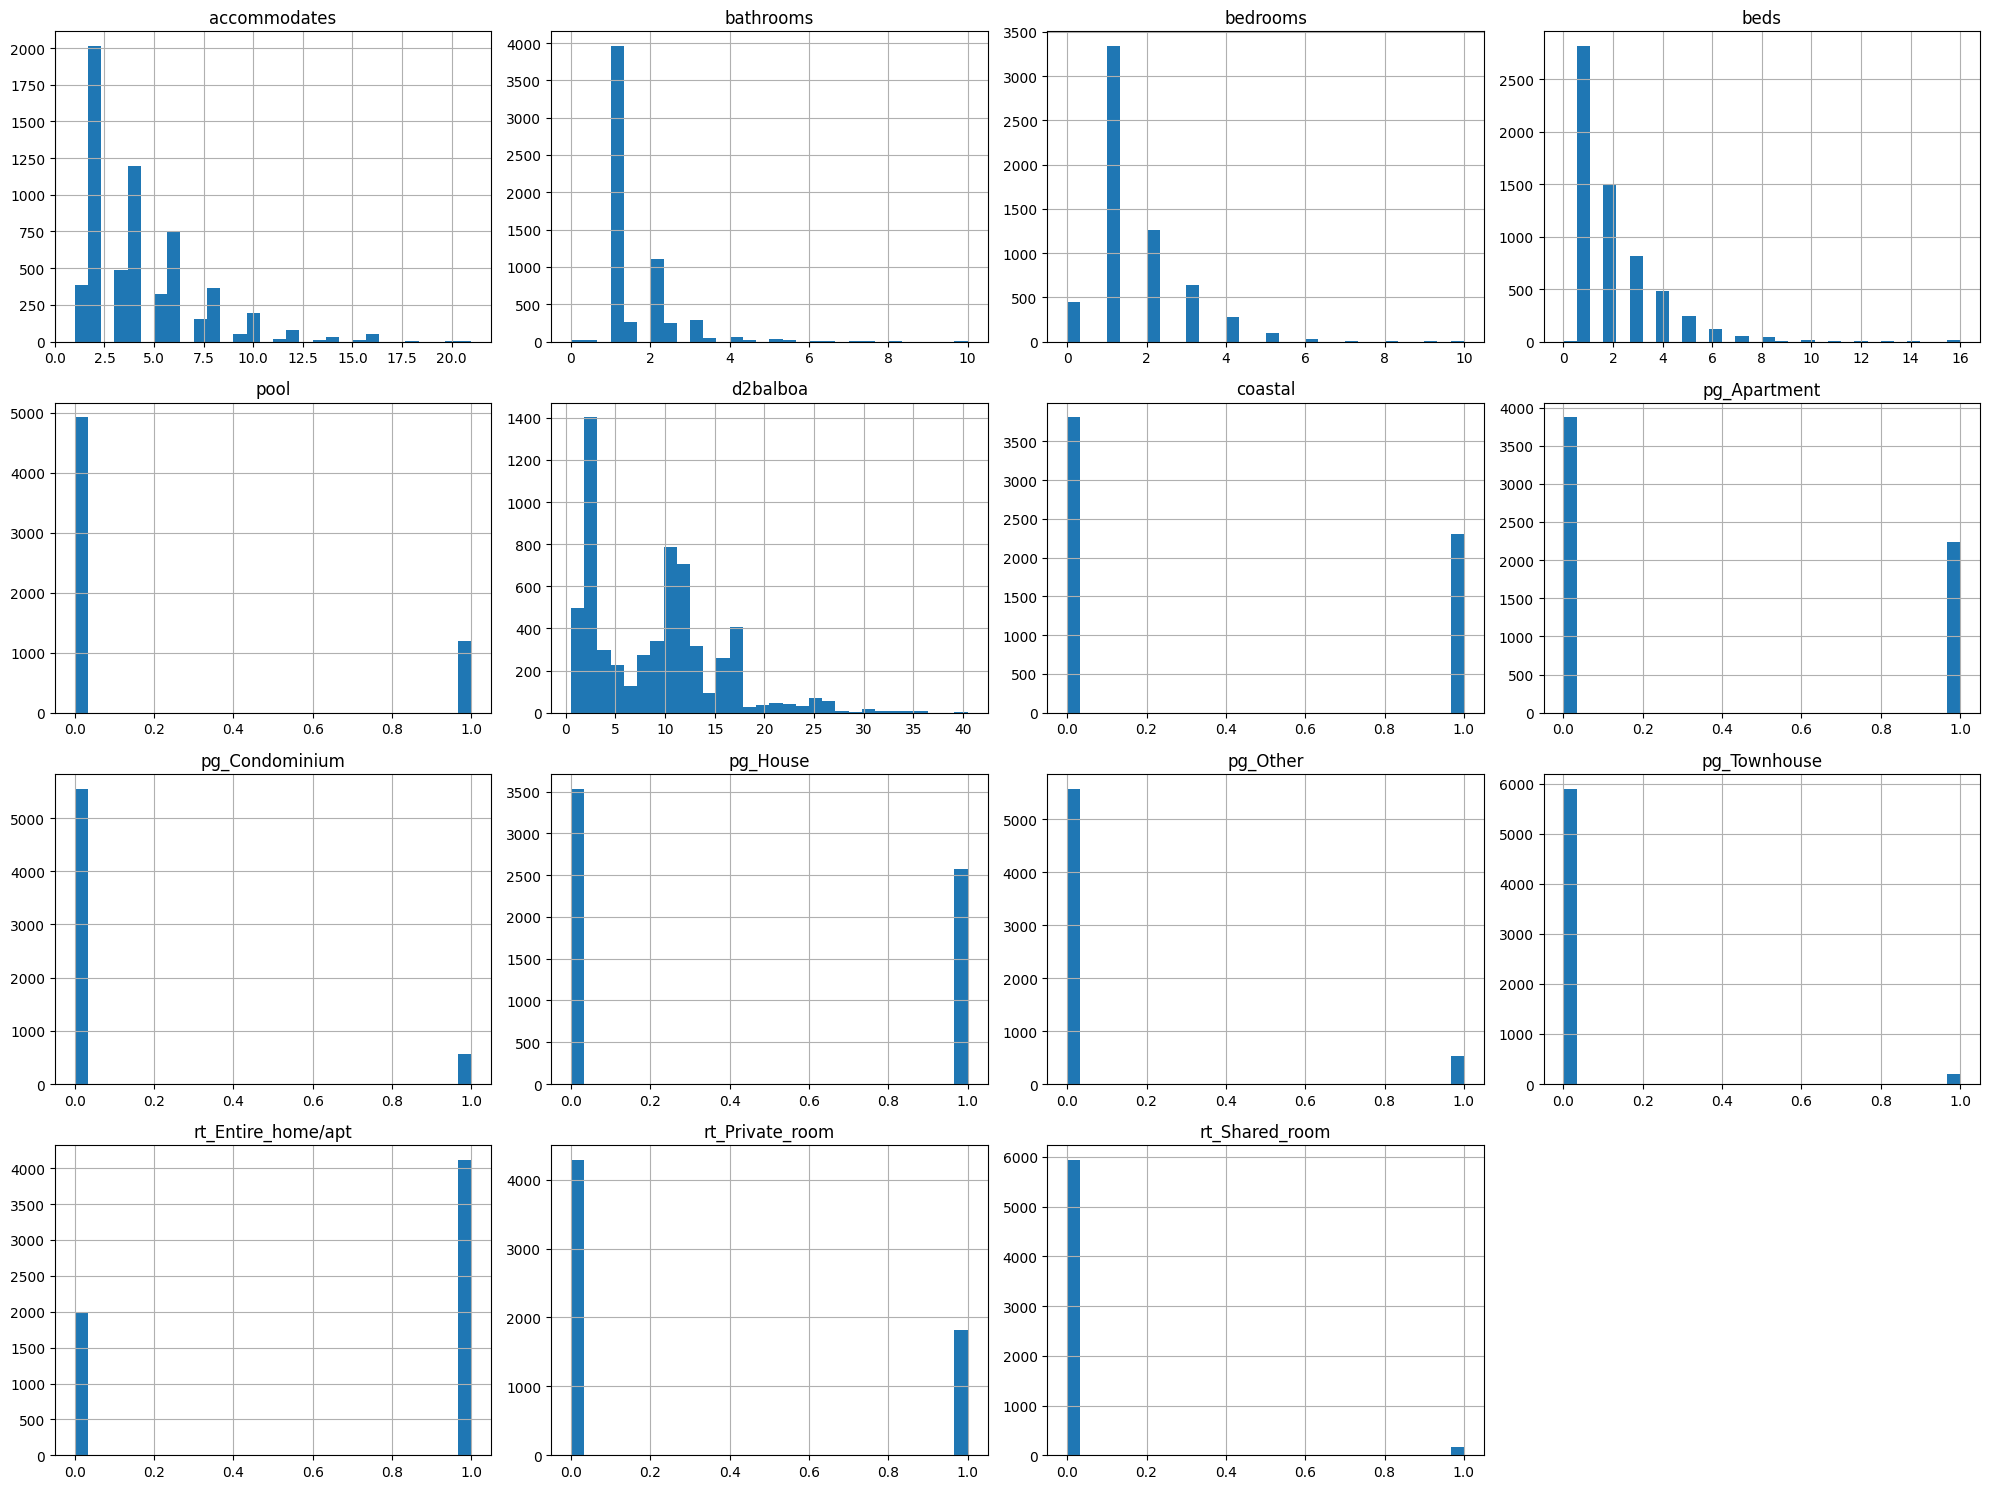

In [25]:
# Plot histograms for all numeric columns
db[numeric_cols].hist(bins=30, figsize=(20, 15))
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

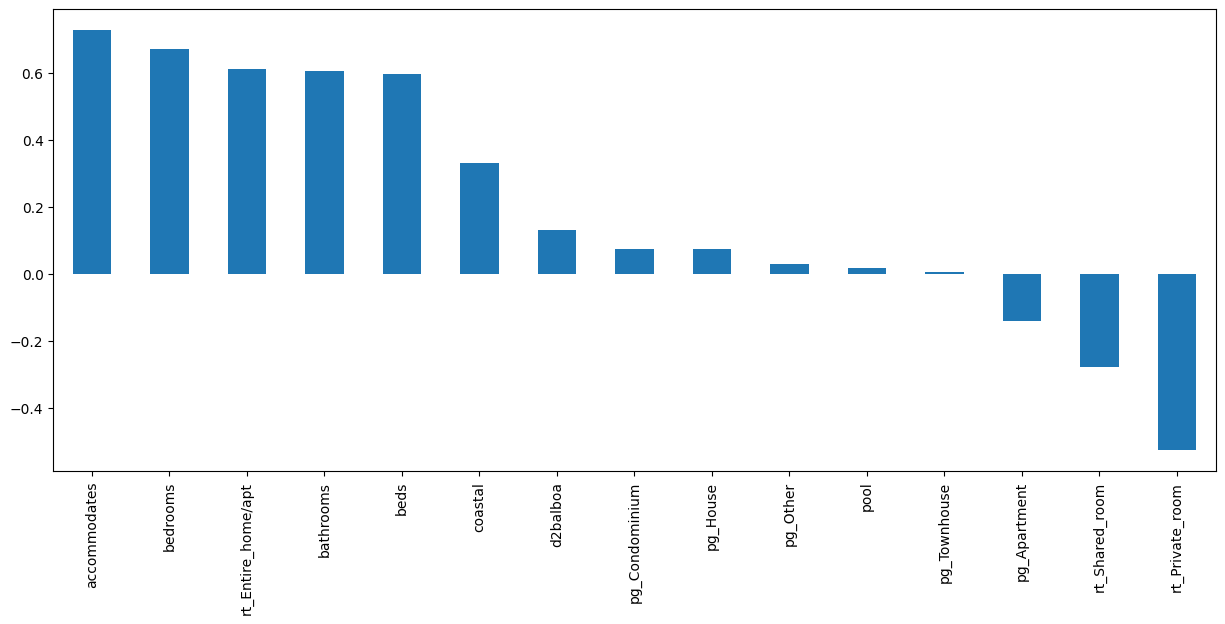

In [26]:
# Plot the correlation of every feature with price and the log price
price_correlation = db.drop(["price", "neighborhood", "geometry", 'id'], axis=1).corr()["log_price"].sort_values(ascending=False)
price_correlation.drop('log_price').plot(kind="bar", figsize=(15, 6))
plt.show()

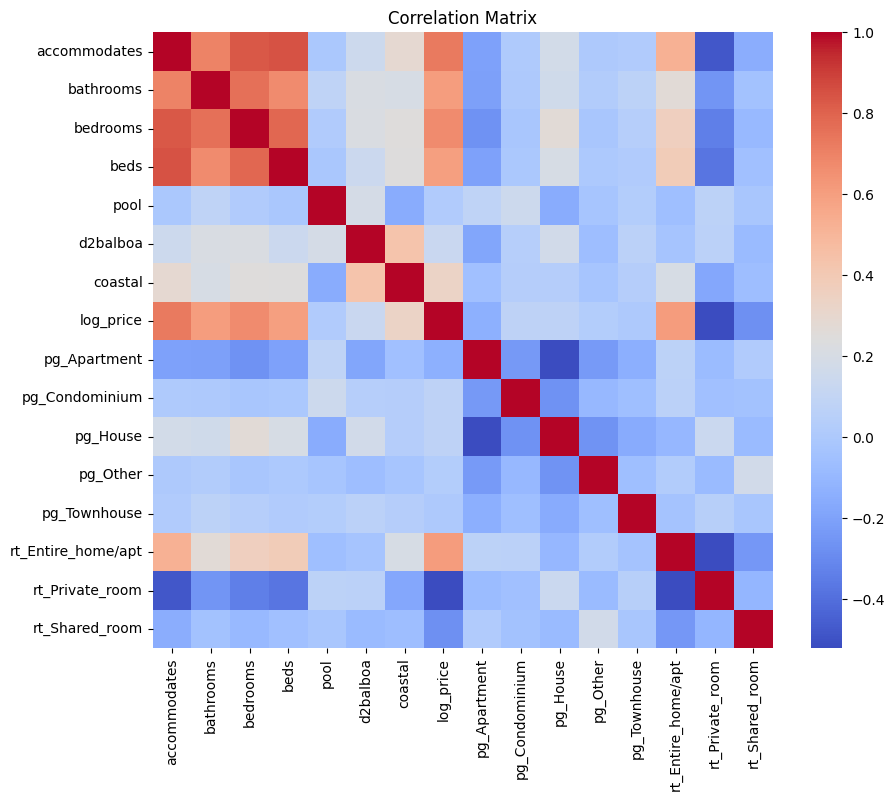

In [27]:
correlation_matrix=db.drop(["price", "neighborhood", "geometry", 'id'], axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", robust=True)
plt.title("Correlation Matrix")
plt.show()

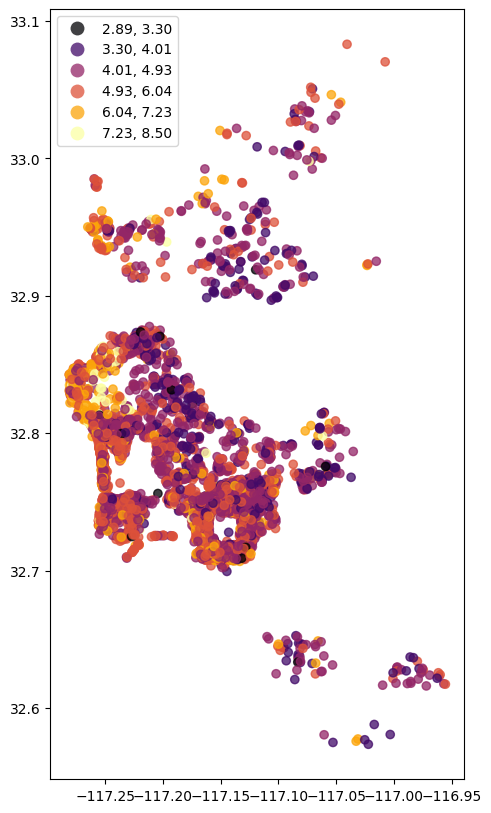

In [28]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
db.plot(
    column="log_price",
    cmap="inferno",
    scheme="percentiles",
    alpha=0.75,
    legend=True,
    ax=ax,
)
plt.show()

**Función `prepare_adjacency_matrix`: Funcionalidad y Necesidad**

La **función `prepare_adjacency_matrix`** es fundamental en el contexto de **Graph Convolutional Networks (GCN)** y **Geographically Weighted Graph Convolutional Networks (GWGCN)**. A continuación, se detalla qué hace esta función y por qué es necesaria en el procesamiento de datos para modelos de redes neuronales basadas en grafos.

---

**1. ¿Qué es una Matriz de Adyacencia?**

Antes de entender la función `prepare_adjacency_matrix`, es crucial comprender qué es una **matriz de adyacencia**.

- **Definición:**  
  Una matriz de adyacencia es una representación matemática de un grafo (o red). Es una matriz cuadrada donde cada elemento `(i, j)` indica la existencia (y a veces el peso) de una conexión (o arista) entre el nodo `i` y el nodo `j`.

- **Propiedades:**
  - **Simétrica:** En grafos no dirigidos, la matriz de adyacencia es simétrica, es decir, `(i, j) = (j, i)`.
  - **Binaria o Ponderada:** Los valores pueden ser `0` o `1` (para indicar ausencia o presencia de una arista) o pueden representar pesos específicos de las conexiones.

---

**2. `prepare_adjacency_matrix`: ¿Qué Hace?**

La función `prepare_adjacency_matrix` generalmente realiza los siguientes pasos para crear una matriz de adyacencia adecuada para modelos GCN o GWGCN:

**2.1. Construcción del Grafo**

- **Identificación de Vecinos:**  
  Utiliza métodos como **K-Nearest Neighbors (KNN)** para determinar qué nodos (por ejemplo, ubicaciones geográficas) están más cercanos entre sí y, por lo tanto, deben estar conectados en el grafo.

- **Criterios de Conexión:**  
  Define reglas específicas para establecer conexiones. Por ejemplo, conectar cada nodo con sus `k` vecinos más cercanos.

**2.2. Creación de la Matriz de Adyacencia**

- **Inicialización:**  
  Comienza con una matriz de ceros de tamaño `(N, N)`, donde `N` es el número de nodos.

- **Asignación de Conexiones:**  
  Para cada par de nodos que cumplen con los criterios de conexión (por ejemplo, los `k` vecinos más cercanos), asigna un valor de `1` (o un peso específico) en las posiciones correspondientes `(i, j)` y `(j, i)` para asegurar la simetría.

**2.3. Normalización (Opcional pero Recomendado)**

- **Normalización de la Matriz:**  
  A menudo, se normaliza la matriz de adyacencia para mejorar la estabilidad y eficiencia del entrenamiento del modelo. Métodos comunes incluyen la normalización de Laplace o la normalización simétrica.

- **Ejemplo de Normalización Simétrica:**
  $$[
  \hat{A} = D^{-\frac{1}{2}} A D^{-\frac{1}{2}}
  ]$$
  donde \( D \) es la matriz diagonal de grados.

**2.4. Manejo de Conexiones Irrelevantes**

- **Filtrado de Ruido:**  
  Puede incluir pasos para eliminar conexiones débiles o irrelevantes que podrían introducir ruido en el modelo.

---

**3. ¿Por Qué Necesitamos la Matriz de Adyacencia?**

La matriz de adyacencia es esencial por varias razones:

**3.1. Definición de la Estructura del Grafo**

- **Relaciones entre Nodos:**  
  La matriz define cómo están interconectados los nodos, lo que es fundamental para que el modelo GCN o GWGCN pueda aprender las relaciones y patrones espaciales o estructurales en los datos.

**3.2. Influencia de la Información Local**

- **Propagación de Información:**  
  En las GCN, la información se propaga a través de las conexiones definidas por la matriz de adyacencia. Esto permite que cada nodo integre información de sus vecinos, capturando así dependencias locales.

**3.3. Eficiencia en el Cálculo**

- **Operaciones Vectorizadas:**  
  Tener una matriz de adyacencia predefinida permite realizar operaciones matriciales eficientes, optimizando el rendimiento durante el entrenamiento y la inferencia del modelo.

**3.4. Incorporación de Conocimiento Geoespacial (en GWGCN)**

- **Ponderaciones Geográficas:**  
  En GWGCN, además de las conexiones básicas, se pueden incorporar ponderaciones basadas en la geografía, como la distancia, para reflejar la influencia relativa entre nodos en función de su proximidad espacial.

---

**4. Consideraciones Adicionales**

**4.1. Selección de Parámetros**

- **Número de Vecinos (`k`):**  
  Determinar un valor adecuado para `k` es crucial. Un `k` demasiado bajo puede resultar en un grafo disperso, mientras que un `k` demasiado alto puede introducir conexiones irrelevantes.

**4.2. Escalabilidad**

- **Grandes Conjuntos de Datos:**  
  Para conjuntos de datos muy grandes, considerar métodos eficientes de búsqueda de vecinos o técnicas de muestreo para construir la matriz de adyacencia sin incurrir en altos costos computacionales.

**4.3. Ponderación de Conexiones**

- **Pesos Basados en Distancia:**  
  En lugar de utilizar una matriz binaria, se pueden asignar pesos a las conexiones basados en la distancia u otros criterios relevantes, lo que puede enriquecer la información proporcionada al modelo.

**4.4. Manejo de Nodos Aislados**

- **Nodos sin Conexiones:**  
  Asegurar que todos los nodos tengan al menos una conexión para evitar que queden aislados en el grafo, lo que podría afectar negativamente el aprendizaje del modelo.

---

La función `prepare_adjacency_matrix` es esencial para:

- **Definir la Estructura del Grafo:** Establece cómo están conectados los nodos en el grafo, reflejando relaciones relevantes en los datos.
  
- **Facilitar el Aprendizaje en Modelos GCN/GWGCN:** Permite que el modelo entienda y aprenda las dependencias locales y globales entre nodos.
  
- **Optimizar Recursos Computacionales:** Una matriz bien construida permite operaciones eficientes durante el entrenamiento y la inferencia del modelo.

Comprender y correctamente implementar la construcción de la matriz de adyacencia es clave para el éxito de los modelos basados en grafos, asegurando que capturen de manera efectiva las relaciones intrínsecas en los datos.

In [29]:
laplacian_knn, knn, a_knn_connected = prepare_adjacency_matrix(db, config['graph']['adj']['k'], True, 'hard')

The weights matrix is fully connected.


In [30]:
check_symmetric(np.array(laplacian_knn))

True

Veamos el resultado de la construcción del grafo:

In [31]:
# Create a NetworkX graph from the adjacency matrix
G = nx.from_numpy_array(a_knn_connected)

# Extract coordinates from the GeoDataFrame
# If your GeoDataFrame is in a projected CRS (e.g., meters), use those coordinates
# If in geographic CRS (e.g., degrees), consider projecting to a suitable CRS for accurate distance representation

# Example for projected CRS:
positions = {i: (geom.x, geom.y) for i, geom in enumerate(db.geometry)}

# If using geographic CRS and prefer to plot using longitude and latitude:
# positions = {i: (geom.longitude, geom.latitude) for i, geom in enumerate(db.geometry)}

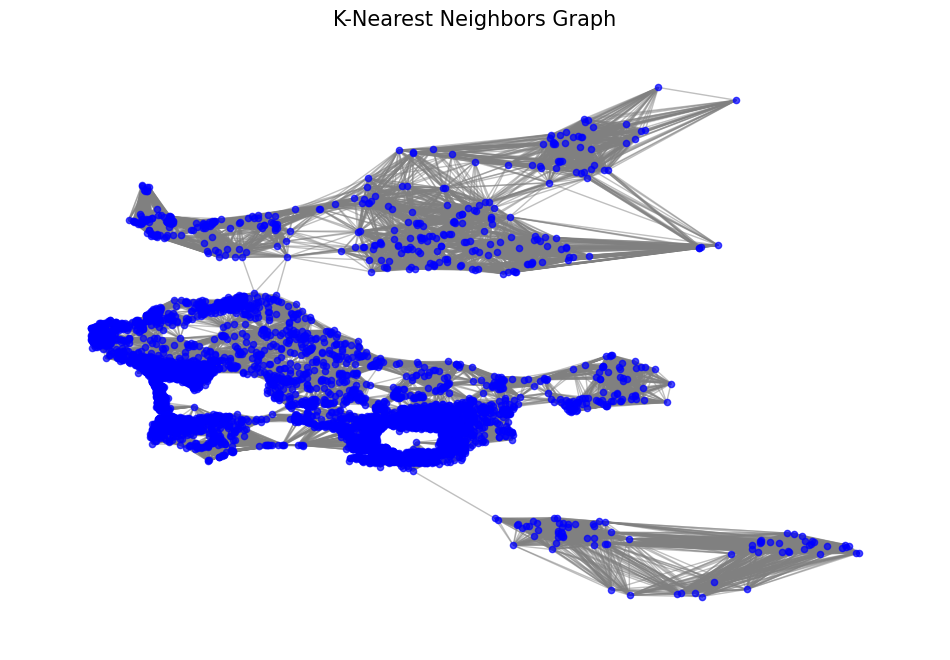

In [32]:
plt.figure(figsize=(12, 8))
nx.draw_networkx_edges(
    G, pos=positions, alpha=0.5, edge_color="gray"
)  # Draw the edges
nx.draw_networkx_nodes(
    G, pos=positions, node_size=20, node_color="blue", alpha=0.7
)  # Draw the nodes
plt.axis("off")
plt.title("K-Nearest Neighbors Graph", fontsize=15)
plt.show()

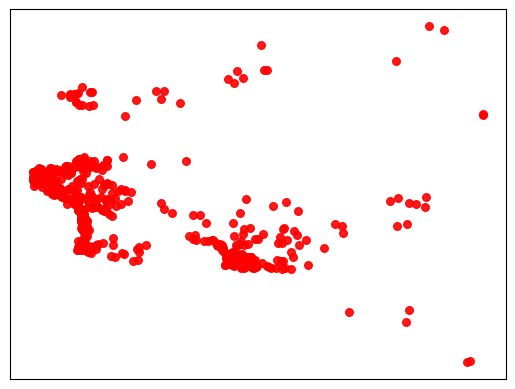

In [33]:
# Example: Highlight nodes with 'price' above a threshold
high_price_nodes = [i for i, price in enumerate(db["log_price"]) if price > 6]
nx.draw_networkx_nodes(
    G,
    pos=positions,
    nodelist=high_price_nodes,
    node_size=30,
    node_color="red",
    alpha=0.9,
)
plt.show()

Podemos graficar de manera interactiva:

In [ ]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = positions[edge[0]]
    x1, y1 = positions[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = [positions[node][0] for node in G.nodes()]
node_y = [positions[node][1] for node in G.nodes()]

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=5,
        color=[],
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

# Coloring nodes based on degree
node_adjacencies = [G.degree(node) for node in G.nodes()]
node_trace.marker.color = node_adjacencies

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Interactive K-Nearest Neighbors Graph',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()

**Determinación del Número Óptimo de Vecinos (`k`) para la Matriz de Adyacencia**

Determinar el valor óptimo de **`k`** en un enfoque de **K-Nearest Neighbors (KNN)** para construir una **matriz de adyacencia** es crucial para el rendimiento y la efectividad de las **Graph Convolutional Networks (GCN)** y **Geographically Weighted Graph Convolutional Networks (GWGCN)**. El valor de `k` dicta cuántos vecinos considera cada nodo al establecer conexiones en el grafo, lo que influye directamente en la estructura del grafo y, por ende, en la capacidad del modelo para aprender patrones significativos.

A continuación, se presentan estrategias y consideraciones exhaustivas para ayudarte a determinar el valor más adecuado de `k` para tu matriz de adyacencia:

---

**1. Comprender el Papel de `k`**

**1.1. Impacto en la Estructura del Grafo**

- **Valores Bajos de `k`:**
  - **Pros:**
    - **Esparsidad:** Resulta en un grafo esparcido, lo cual es computacionalmente eficiente.
    - **Localidad:** Enfatiza relaciones locales, capturando patrones detallados.
  - **Contras:**
    - **Grafos Desconectados:** Puede llevar a componentes desconectados, dificultando el flujo de información en todo el grafo.
    - **Contexto Limitado:** Los nodos tienen menos conexiones, lo que puede perder información contextual más amplia.

- **Valores Altos de `k`:**
  - **Pros:**
    - **Conectividad:** Mejora la conectividad del grafo, asegurando que la información pueda propagarse eficazmente.
    - **Conciencia Contextual:** Incorpora información contextual más amplia, beneficiosa para capturar patrones globales.
  - **Contras:**
    - **Sobreajuste:** Puede introducir ruido al conectar nodos que no están verdaderamente relacionados, llevando al sobreajuste.
    - **Sobrecarga Computacional:** Aumenta el número de aristas, haciendo las operaciones más intensivas computacionalmente.
    - **Pérdida de Localidad:** Diluye el énfasis en relaciones locales, potencialmente ignorando patrones detallados importantes.

**1.2. Equilibrio**

Seleccionar `k` implica equilibrar entre la **especificidad local** y la **conectividad global**. Un `k` óptimo asegura que el grafo esté **suficientemente conectado** para permitir una propagación de información efectiva sin introducir ruido excesivo o cargas computacionales innecesarias.

---

**2. Estrategias para Determinar el `k` Óptimo**

**2.1. Conocimiento del Dominio y Perspectivas Contextuales**

- **Aprovechar la Experiencia:**
  - Utiliza el conocimiento sobre el dominio específico o el conjunto de datos para informar tu elección de `k`.
  - Por ejemplo, en datos espaciales, considera la densidad y distribución de puntos. En áreas densamente pobladas, un `k` más pequeño podría ser suficiente, mientras que en regiones más dispersas, podría requerirse un `k` mayor para asegurar la conectividad.

- **Entender las Relaciones:**
  - Evalúa las relaciones inherentes en tus datos. Si se espera que los nodos tengan interacciones locales fuertes, un `k` menor puede ser apropiado. Por el contrario, si las interacciones más amplias son significativas, un `k` mayor podría ser necesario.

**2.2. Evaluación Empírica a través de Validación Cruzada**

- **Métricas de Rendimiento del Modelo:**
  - Experimenta con una variedad de valores de `k` y evalúa el rendimiento del modelo utilizando métricas como **Accuracy**, **F1-Score**, **Mean Squared Error (MSE)**, u otras relevantes para tu tarea.

- **Validación Cruzada:**
  - Implementa validación cruzada para evaluar cómo diferentes valores de `k` se generalizan a datos no vistos.
  - Selecciona el `k` que consistentemente ofrezca el mejor rendimiento a través de los pliegues de validación.

- **Búsqueda en Grid (Grid Search):**
  - Realiza una búsqueda sistemática sobre un rango predefinido de valores de `k` para identificar el valor óptimo basado en métricas de rendimiento.

**2.3. Análisis de Propiedades del Grafo**

- **Distribución de Grados:**
  - Examina cómo diferentes valores de `k` afectan la distribución de grados en tu grafo.
  - Asegúrate de que la distribución se alinee con los patrones esperados (por ejemplo, evitando distribuciones excesivamente sesgadas a menos que estén justificadas).

- **Análisis de Conectividad:**
  - Evalúa si el grafo permanece conectado o forma componentes aislados para varios valores de `k`.
  - Busca una estructura de grafo que mantenga una conectividad suficiente sin volverse excesivamente denso.

- **Coeficiente de Agrupamiento:**
  - Evalúa el coeficiente de agrupamiento para comprender la tendencia de los nodos a formar clústeres.
  - Un coeficiente de agrupamiento equilibrado puede indicar una mezcla saludable de estructuras locales y globales.

**2.4. Técnicas de Visualización**

- **Visualización del Grafo:**
  - Visualiza el grafo para diferentes valores de `k` para obtener una comprensión intuitiva de cómo cambian las conexiones.
  - Identifica patrones como clústeres, centros de conexión (hubs) o nodos aislados que puedan influir en el rendimiento del modelo.

- **Mapas de Calor de la Matriz de Adyacencia:**
  - Crea mapas de calor de la matriz de adyacencia para diferentes valores de `k` para observar la densidad y distribución de conexiones.

- **Distribución de Distancias:**
  - Grafica la distribución de distancias entre nodos conectados para varios valores de `k` para asegurar que las conexiones tengan sentido lógico dentro del contexto de tus datos.

**2.5. Consideraciones Computacionales**

- **Escalabilidad:**
  - Para conjuntos de datos grandes, valores altos de `k` pueden llevar a una sobrecarga computacional significativa.
  - Optimiza tu elección de `k` para equilibrar el rendimiento con la factibilidad computacional.

- **Representaciones Esparsas:**
  - Utiliza representaciones de matrices esparsas para manejar valores altos de `k` de manera eficiente, reduciendo el consumo de memoria y acelerando las operaciones.

**2.6. Estabilidad a Través de Diferentes Conjuntos de Datos**

- **Generalización:**
  - Si planeas aplicar tu modelo a múltiples conjuntos de datos o diferentes subconjuntos de datos, asegúrate de que el `k` elegido ofrezca un rendimiento consistente a través de diferentes escenarios.

- **Robustez:**
  - Un `k` que funcione bien en diversas condiciones indica robustez y mejora la fiabilidad del modelo.

---

**3. Recomendaciones Prácticas**

**3.1. Comenzar con un Rango Razonable**

- **Rango Inicial:**
  - Comienza experimentando con valores de `k` que sean proporcionales al grado promedio de nodos en conjuntos de datos similares.
  - Puntos de partida comunes podrían ser `k = 5`, `k = 10`, `k = 15`, etc., dependiendo del tamaño y densidad del conjunto de datos.

**3.2. Pruebas Incrementales**

- **Ajuste Fino:**
  - Después de identificar un rango general donde el rendimiento es óptimo, ajusta `k` dentro de ese rango para precisar el valor óptimo.

- **Evitar Extremos:**
  - Evita valores de `k` demasiado bajos o demasiado altos a menos que estén justificados por requisitos específicos del dominio.

**3.3. Considerar Métodos Adaptativos de `k`**

- **Vecinos Variables:**
  - En lugar de un `k` fijo para todos los nodos, considera métodos donde `k` varía según la densidad del nodo u otras características locales.

- **Conexiones Basadas en Umbral:**
  - Establece conexiones basadas en un umbral de distancia en lugar de un número fijo de vecinos, permitiendo una conectividad adaptativa.

**3.4. Incorporar Retroalimentación del Modelo**

- **Refinamiento Iterativo:**
  - Utiliza la retroalimentación de las evaluaciones del modelo para ajustar iterativamente `k`. Si el modelo presenta un rendimiento inferior, reevaluar si `k` es demasiado bajo o alto y ajustarlo en consecuencia.

- **Análisis de Errores:**
  - Analiza los errores del modelo espacialmente para determinar si ciertas regiones o clústeres requieren niveles de conectividad diferentes.

---


**4. Consideraciones Adicionales**

**4.1. Impacto en Sobreajuste y Subajuste**

- **Bajo `k`:**
  - Puede llevar a un **subajuste** ya que el modelo carece de información contextual suficiente.
  
- **Alto `k`:**
  - Riesgo de **sobreajuste** debido a la incorporación de conexiones irrelevantes que introducen ruido.

**5.2. Enfoques Híbridos**

- **Múltiples Valores de `k`:**
  - Combina múltiples valores de `k` o capas con diferentes `k` para capturar relaciones a múltiples escalas.
  
- **Integración de Características:**
  - Incorpora características adicionales que capturen niveles variables de localidad y conectividad junto con un solo `k`.

**5.3. Uso de Técnicas de Validación**

- **Conjuntos de Validación Separados:**
  - Utiliza conjuntos de validación separados para evaluar cómo diferentes valores de `k` funcionan en datos no vistos.

- **Optimización de Hiperparámetros:**
  - Implementa técnicas de optimización de hiperparámetros, como la búsqueda en grid o la optimización bayesiana, para explorar sistemáticamente y identificar el mejor `k`.

---
Determinar el número óptimo de vecinos `k` para construir una matriz de adyacencia es un equilibrio entre **capturar relaciones significativas** y **mantener la eficiencia computacional**. A continuación, se destacan los puntos clave:

- **Equilibrio entre Conectividad y Esparsidad:** Evita grafos excesivamente esparsos que dificulten el flujo de información y grafos excesivamente densos que introduzcan ruido.
  
- **Evaluación Empírica:** Utiliza validación cruzada y métricas de rendimiento para guiar tu elección.
  
- **Aprovechar el Conocimiento del Dominio:** Utiliza perspectivas sobre la estructura inherente de los datos para informar la selección de `k`.
  
- **Analizar Propiedades del Grafo:** Comprende cómo diferentes valores de `k` afectan las propiedades estructurales del grafo.
  
- **Refinamiento Iterativo:** Ajusta `k` continuamente basado en la retroalimentación del modelo y evaluaciones de rendimiento.

Al seleccionar cuidadosamente `k`, mejoras la capacidad de tu modelo para aprender y generalizar a partir de los datos, lo que conduce a predicciones más precisas y confiables en tareas que utilizan Graph Convolutional Networks.

---

In [33]:
adj = torch.FloatTensor(laplacian_knn).to(device)

In [34]:
# the list of independent variables used for regression (may be used for feature engineering)
variable_names = [
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    # "pool",
    # "d2balboa",
    # "coastal",
    # "pg_Apartment",
    # "pg_Condominium",
    # "pg_House",
    # "pg_Other",
    # "pg_Townhouse",
    # "rt_Entire_home/apt",
    # "rt_Private_room",
    # "rt_Shared_room",
]

In [35]:
### Params settings for the model on limited Xs
n_labels = 1  # #output feature dimension:log_price
n_features = len(variable_names)  # #input feature dimensional vector
num_nodes = adj.size(0)

In [36]:
### The observations for data regression
x_tensor = torch.FloatTensor(db[variable_names].values.tolist()).to(device)
y_tensor = torch.FloatTensor(db[["log_price"]].values.tolist()).to(device)
idx_all = torch.LongTensor(db.index.values).to(device)

In [37]:
class ModelFactory:
    """Factory class to create different types of GCN models."""

    @staticmethod
    def create(
        model_type: str,
        in_features: int,
        out_features: int,
        hidden: list,
        dropouts: list,
        num_nodes: int
    ) -> nn.Module:
        if model_type == "GCN":
            return GCN(in_features, out_features, hidden, dropouts).to(device)
        elif model_type == "GWGCN":
            return GWGCN(
                in_features, out_features, hidden, dropouts, num_nodes
            ).to(device)
        else:
            raise ValueError(f"Unknown model type: {model_type}")

#### Training

In [38]:
model_type = "GWGCN"  # or "GCN"
model = ModelFactory.create(
    model_type,
    n_features,
    n_labels,
    config["model"]["hidden_layers"],
    config["model"]['dropouts'],
    num_nodes
)
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=config["model"]["learning_rate"],
    weight_decay=config["model"]["learning_rate"] * config["model"]["weight_decay_ratio"],
    amsgrad=True
)

In [39]:
lowest_mean_global_error = np.inf
min_global_error_epoch = -1
train_loss_arr = []
error_arr = []

for i in range(config['training']['epochs']):
    train_loss = step(
        model, optimizer, x_tensor, idx_all, y_tensor, adj
    )  # For demo, train with all ids "idx_all"
    train_loss_arr.append(train_loss)
    global_error = evaluate_error(
        model, x_tensor, idx_all, y_tensor, adj, config["training"]["error_type"]
    )  # For demo, evaluate with again all ids "idx_all"
    error_arr.append(global_error*100)

    if global_error < lowest_mean_global_error:
        lowest_mean_global_error = global_error
        output, target = return_results(model, x_tensor, idx_all, y_tensor, adj)
        min_global_error_epoch = i

    if i % config['training']['print_interval'] == 0 or i == config["training"]["epochs"] - 1:
        print(f"epoch: {i} --train_loss: {train_loss:.4f} --global_error: {global_error*100:.2f} %")

epoch: 0 --train_loss: 5336.0625 --global_error: 1132.94 %
epoch: 1000 --train_loss: 0.5190 --global_error: 10.84 %
epoch: 2000 --train_loss: 0.4797 --global_error: 10.45 %
epoch: 3000 --train_loss: 0.4590 --global_error: 10.19 %
epoch: 4000 --train_loss: 0.4413 --global_error: 9.95 %
epoch: 5000 --train_loss: 0.4270 --global_error: 9.82 %
epoch: 6000 --train_loss: 0.4097 --global_error: 9.64 %
epoch: 7000 --train_loss: 0.4090 --global_error: 9.55 %
epoch: 8000 --train_loss: 0.3994 --global_error: 9.44 %
epoch: 9000 --train_loss: 0.3927 --global_error: 9.33 %
epoch: 10000 --train_loss: 0.3845 --global_error: 9.25 %
epoch: 11000 --train_loss: 0.3769 --global_error: 9.16 %
epoch: 12000 --train_loss: 0.3709 --global_error: 9.08 %
epoch: 13000 --train_loss: 0.3763 --global_error: 9.00 %
epoch: 14000 --train_loss: 0.3743 --global_error: 8.94 %
epoch: 15000 --train_loss: 0.3657 --global_error: 8.88 %
epoch: 16000 --train_loss: 0.3645 --global_error: 8.81 %
epoch: 17000 --train_loss: 0.3579 -

In [40]:
torch.save(model.state_dict(), './Data/Model/model_gwgcn.pth')

In [65]:
model = ModelFactory.create(
    model_type,
    n_features,
    n_labels,
    config["model"]["hidden_layers"],
    config["model"]["dropouts"],
    num_nodes
)

In [66]:
model.load_state_dict(
    torch.load("./Data/Model/model_gwgcn.pth", weights_only=True)
)
model.eval()

GWGCN(
  (layers): Sequential(
    (GWGraphConvolution_0): GWGraphConvolution(
      (activation): ReLU()
    )
  )
  (out_layer): GWGraphConvolution()
)

In [67]:
output, target = return_results(model, x_tensor, idx_all, y_tensor, adj)

#### Estadística y Visualización

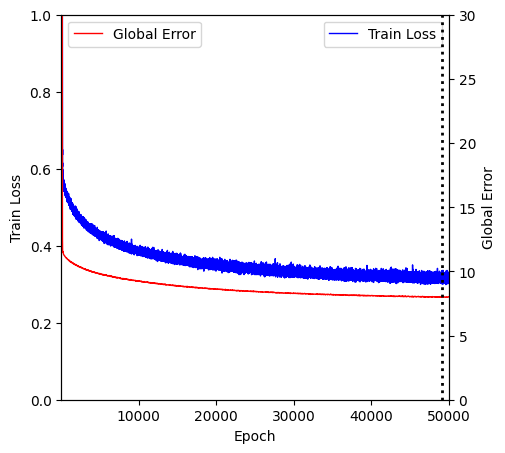

In [68]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(train_loss_arr, lw=1, color="b", alpha=1, label="Train Loss")
ax.set_xlabel("Epoch")
ax.set_xlim(1, config['training']['epochs'])
ax.set_xlabel("Epoch")
ax.set_ylim(0, 1)
ax.set_ylabel("Train Loss")
ax.legend(loc='upper right')
ax2 = ax.twinx()
ax2.plot(error_arr, lw=1, color="r", alpha=1, label="Global Error")
ax2.set_xlim(1, config["training"]["epochs"])
ax2.set_ylabel("Global Error")
ax2.set_ylim(0, 30)
ax2.legend(loc='upper left')
plt.axvline(min_global_error_epoch, linestyle="dotted", linewidth=2, color="black")
plt.show()

In [69]:
error = (mae(output, target) / target).mean()
error

np.float32(0.06612976)

In [70]:
rsq = r2_score(target, output)
rsq  # R-square of model fit

0.6015727519989014

In [71]:
Ierror = esda.moran.Moran(output - target, knn)
print(
    "Errors  moransI: "
    + str(Ierror.I)
    + "  Z_I: "
    + str(Ierror.z_norm)
    + " p-value: "
    + str(Ierror.p_sim)
)

Errors  moransI: -0.023207041436530258  Z_I: -8.512932017239704 p-value: 0.001


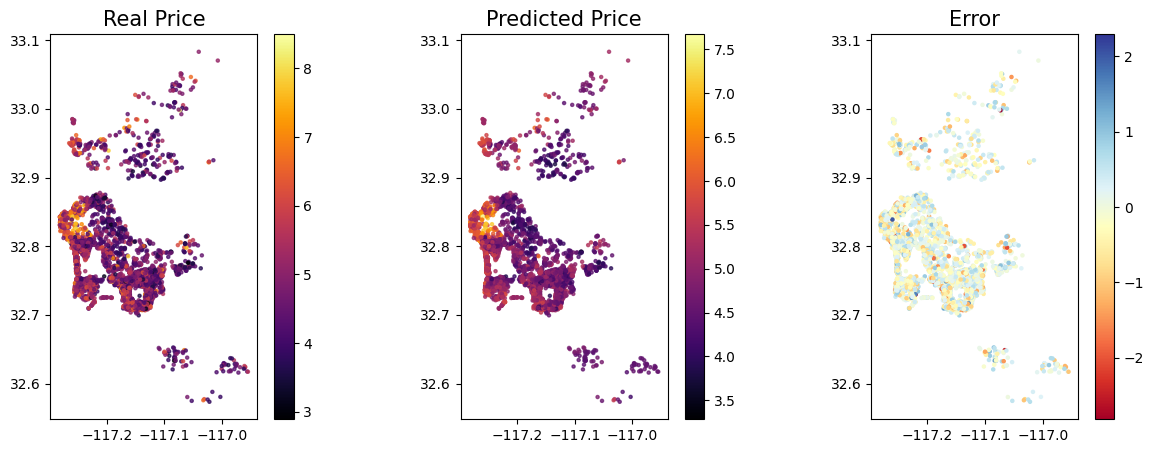

In [72]:
dbplot = db.loc[:, ["log_price", "geometry"]].copy()
dbplot["pred"] = output
dbplot["error"] = output - db[["log_price"]].values

f, ax = plt.subplots(1, 3, figsize=(15, 5))

dbplot.plot(column="log_price", cmap="inferno", s=5, alpha=0.75, legend=True, ax=ax[0])
dbplot.plot(column="pred", cmap="inferno", s=5, alpha=0.75, legend=True, ax=ax[1])
dbplot.plot(column="error", cmap="RdYlBu", s=5, alpha=1, legend=True, ax=ax[2])
ax[0].set_title("Real Price", fontsize=15)
ax[1].set_title("Predicted Price", fontsize=15)
ax[2].set_title("Error", fontsize=15)
plt.show()

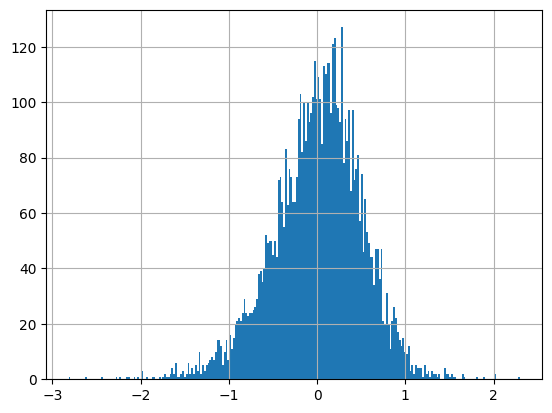

In [73]:
dbplot['error'].hist(bins=250)
plt.show()

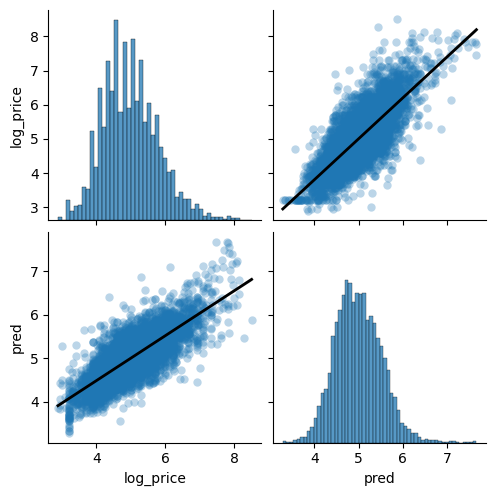

In [74]:
sns.pairplot(
    dbplot.drop("error", axis=1),
    diag_kind="hist",
    kind="reg",
    plot_kws={
        "line_kws": {"color": "black", "lw": 2},
        "scatter_kws": {"linewidths": 0, "alpha": 0.3},
    },
)
plt.show()

#### Ejercicios

**Pregunta 1:**
¿Cuál es la principal diferencia entre una Graph Convolutional Network (GCN) estándar y una Geographically Weighted Graph Convolutional Network (GWGCN)?

a) GWGCN utiliza datos geoespaciales, mientras que GCN no.

b) GCN puede manejar datos de texto, mientras que GWGCN está limitado a datos numéricos.

c) GWGCN incorpora ponderaciones geográficas en la convolución, a diferencia de GCN estándar.

d) GCN estándar es más eficiente computacionalmente que GWGCN.

**Pregunta 2:**
¿Cuál de las siguientes aplicaciones es más adecuada para una GWGCN?

a) Análisis de sentimiento en redes sociales.

b) Predicción de precios inmobiliarios basados en la ubicación geográfica.

c) Reconocimiento de voz en tiempo real.

d) Traducción automática de idiomas.

**Pregunta 3:**
Define brevemente qué es una Graph Convolutional Network (GCN) y cómo se aplica en el análisis de datos.

**Pregunta 4:**
Explica cómo la incorporación de información geográfica en GWGCN puede mejorar la predicción en comparación con una GCN estándar.


**Pregunta 5:**
Describe el proceso de construcción de una GWGCN, incluyendo la preparación de los datos geoespaciales y la integración de estos en la arquitectura de la red.

**Pregunta 6:**
¿Cuáles son las principales ventajas y limitaciones de utilizar GWGCN en comparación con otros modelos de redes neuronales para datos geoespaciales?

**Pregunta 7:**
Supón que tienes un conjunto de datos de ventas de casas con información geográfica. ¿Cómo utilizarías GWGCN para predecir el precio de una casa? Describe los pasos principales.

**Pregunta 8:**
Imagina que una GWGCN está mostrando un rendimiento inferior al esperado en una tarea de clasificación de zonas urbanas. ¿Qué aspectos revisarías y ajustarías para mejorar su desempeño?

**Pregunta 9:**
¿En qué escenarios sería más beneficioso utilizar una GWGCN en lugar de una GCN estándar? Justifica tu respuesta con ejemplos.

**Pregunta 10:**
Discute cómo la elección de la métrica de evaluación puede afectar la interpretación del rendimiento de una GWGCN en una tarea específica.


#### Referencias

* https://github.com/dizhu-gis/SRGCNN

**Referencias Adicionales**

- **PyTorch Documentation:** [https://pytorch.org/docs/stable/index.html](https://pytorch.org/docs/stable/index.html)
- **Scikit-Learn Nearest Neighbors:** [https://scikit-learn.org/stable/modules/neighbors.html](https://scikit-learn.org/stable/modules/neighbors.html)
- **Graph Convolutional Networks Tutorial:** [https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html)
- **Geographically Weighted Regression:** [https://geostatistics.tamu.edu/courses/GR1/Fall2006/lectures/Lecture9.pdf](https://geostatistics.tamu.edu/courses/GR1/Fall2006/lectures/Lecture9.pdf)

---

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)